In [2]:
import os
os.getcwd()

'/data/db638/fewshotlocal'

In [3]:
import torch
from torch.nn import NLLLoss, Conv2d
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn

%matplotlib inline
import pylab as pl
from IPython import display
import time

from helpful_files.networks import Network
from helpful_files.training import *

In [4]:
# Set Important Values

# General settings
datapath = '/data/db638/'                     # The location of your train, test, repr, and query folders. Make sure it ends in '/'!
savepath = 'myModel-111.pth'        # Where should your trained model(s) be saved, and under what name?
gpu = 1                             # What gpu do you wish to train on?
workers = 4                         # Number of cpu worker processes to use for data loading
epoch = 10                          # Number of passes over the dataset before the learning rate is cut
ncuts = 5                           # Number of times to cut the learning rate before training completes
verbosity = 50                      # How many batches in between status updates 
ensemble = 4                        # How many models to train in parallel
torch.cuda.set_device(gpu)
cudnn.benchmark = True

# Batch construction
way = 10                            # Number of classes per batch during training
trainshot = 5                       # Number of images per class used to form prototypes
testshot = 10                       # Number of images per class used to make predictions

# Model construction
folding = True                      # Use batch folding?
covariance_pooling = True           # Use covariance pooling?
localizing = True                   # Use localization?
fewshot_local = True                # If you are using localization: few-shot, or parametric? Few-shot if True, param if False
network_width = 64                  # Number of channels at every layer of the network

# Data loading
augmentation_flipping = True        # Horizontal flip data augmentation
include_masks = (localizing         # Include or ignore the bounding box annotations?
                 and fewshot_local)

In [5]:
# Load Training Data

d_boxes = torch.load('/data/db638/fewshotlocal/helpful_files/box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

if folding:
    # Batch folding has no reference/query distinction
    shots = [trainshot+testshot]
else:
    # Standard setup
    shots = [trainshot, testshot]
if localizing and fewshot_local and not folding:
    # Unfolded prototype localizers need another set of reference images to inform foreground/background predictions
    shots = [trainshot, trainshot, testshot-trainshot]
    
train_dataset = datasets.ImageFolder(
    datapath+'train', 
    loader = lambda x: load_transform(x, d_boxes, transform, augmentation_flipping, include_masks))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset, way, shots),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')

Data loaded!


In [8]:
print(list(d_boxes.keys())[0])

/data/db638/train/3171/4c72b1a7b6a86b8de95425db8cd03384.bmp


In [7]:
new_d_boxes = dict()
for key, value in d_boxes.items():
    new_key = "/data/db638/"+key[3:]
    new_d_boxes[new_key] = value

d_boxes = new_d_boxes
    

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)

        self.relu = nn.ReLU()

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
      
        self.conv4 = conv3x3(inplanes, planes)
        self.bn4 = nn.BatchNorm2d(planes)

        self.maxpool = nn.MaxPool2d(stride)

        self.downsample = downsample
        self.stride = stride
        self.num_batches_tracked = 0

    def forward(self, x):
        self.num_batches_tracked += 1

        residual = x
        residual = self.conv4(residual)
        residual = self.bn4(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += residual
        out = self.relu(out)
        out = self.maxpool(out)
        
        return out


class ResNet(nn.Module):

    def __init__(self, block):
        self.inplanes = 3
        super(ResNet, self).__init__()
        self.layer1 = BasicBlock(3,64, 2)
        self.layer2 = BasicBlock(64,128, 2)
        self.layer3 = BasicBlock(128,256, 2)
        self.layer4 = BasicBlock(256,512, 1)
        self.layer5 = nn.Conv2d(512,128, 1)

        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # TODO: is this fine?
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x


def resnet12():
    """Constructs a ResNet-12 model.
    """
    model = ResNet(BasicBlock)
    return model

In [10]:
# Make Models
    
models = [Network(network_width, folding, covariance_pooling,
                  localizing, fewshot_local, shots).cuda()
          for i in range(ensemble)]
for model in models:
    model.encode = resnet12().cuda()
optimizer = [optim.Adam(m.parameters(), lr=.001) for m in models]
scheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in optimizer]
criterion = NLLLoss().cuda()

nweights = sum([i.numel() for i in list(models[0].parameters())])
print(nweights,"parameters in each neural net.")
print('Ready to go!')

9440256 parameters in each neural net.
Ready to go!


In [11]:
#                                             TRAINING

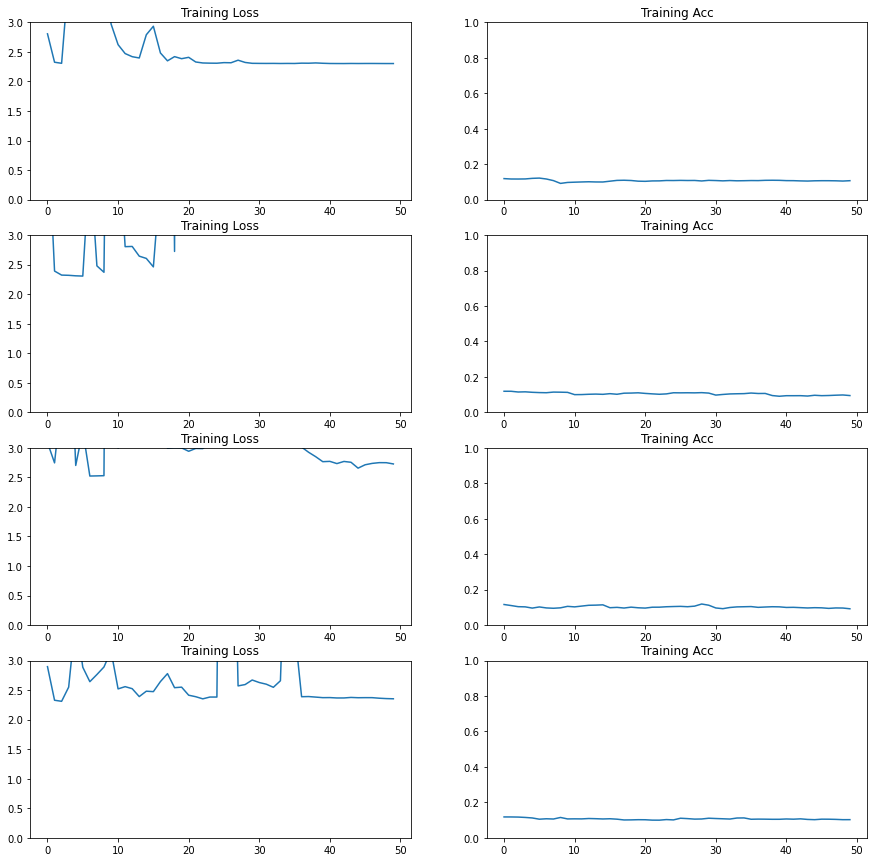

Training loss is: [2.3037620410440107, 3.8309199563000975, 2.727243488774382, 2.3525996069706028]
Training accuracy is: [0.10698587127158557, 0.09484039769754052, 0.09203558346415484, 0.10237571951857685]

Approximately 0.51 hours to completion

Training complete: 25.35 hours total


In [12]:
# Do the Thing!

start = time.time()
trainlosses, acctracker = [[] for _ in range(ensemble)],[[] for _ in range(ensemble)]
epochs = ncuts*epoch
for e in range(epochs):
    
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in scheduler]
    
    # Train for one epoch
    trainloss, acc = train(train_loader, models, optimizer, criterion, way, shots, verbosity)
    
    # Update the graphics, report
    display.clear_output(wait=True)
    for j in range(ensemble):
        trainlosses[j].append(trainloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(ensemble):
        pl.subplot(ensemble,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.ylim((0,3))
        pl.title("Training Loss")
        pl.subplot(ensemble,2,2*i+2)
        pl.plot(acctracker[i])
        pl.ylim((0,1))
        pl.title("Training Acc")
    pl.show()
    print("Training loss is: "+str(trainloss)+
            "\nTraining accuracy is: "+str(acc)+"\n")
    print("Approximately %.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
    
print("Training complete: %.2f hours total" % ((time.time()-start)/3600)) 

In [13]:
# Save the model

torch.save([m.encode.cpu().state_dict() for m in models], savepath)

# If using parametric localization, save the extra parameters
if localizing and not fewshot_local:
    torch.save([m.postprocess.centroids.cpu() for m in models], 
               savepath[:savepath.rfind('.')]+'_localizers'+savepath[savepath.rfind('.'):])
print("Models saved!")

Models saved!


In [ ]:
# Shut down the notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();